## Wstęp

Premier League to prawdopodobnie najbardziej atrakcyjna dla kibiców liga piłkarska na świecie
Pokazują to w szczególności statystyki oglądalności, w których PL absolutnie dominuje inne ligi.
Wpływ na to mają z pewnością wielomilionowe budżety klubów, pozwalające sprowadzać wschodzące talenty 
czy uznane już gwiazdy, świetna otoczka około-footballowa oraz wielkie marki piłkarskie.
Kluby te, często liczące ponad 120 lat, potrafiły przyciągać całe pokolenia kibiców wzbudzając w nich przywiązanie i
dostarczając świetne boiskowe widowisko, które zostanie wzięte pod lupę. Celem tej pracy jest bowiem znalezienie
klubu, grającego najatrakcyjniejszy football w Premier League w sezonie 2017/2018.

### Dane

#### Opis danych

Szukamy najatrakcyjniejszego piłkarsko zespołu w Premier League w sezonie 2017/2018 na podstawie:<br />
- Strzelonych goli - G+ (stymulanta)<br />
- Straconych goli - G- (stymulanta)<br />
- Zółtych kartek - YC (destymulanta)<br />
- Czerwonych kartek - RC (destymulanta)<br />
- Remisów - D (destymulanta)<br />
- Ilości podań do tyłu w stosunku do ilości kontaktów z piłką-BPPT(destymulanta)<br />
Źródło danych: https://www.kaggle.com/datasets/zaeemnalla/premier-league

#### Import bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing
from tabulate import tabulate
import scipy.cluster.hierarchy as shc

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

import warnings #tylko tchórze boją się warningów!
warnings.filterwarnings('ignore') 
pd.set_option('display.float_format', lambda x: '%.3f' % x)


#### Przygotowanie danych

In [2]:
#Ładna tabelka
def table(ta):
    print(tabulate(ta, headers='keys', tablefmt='psql'))

rawData = pd.read_csv('stats.csv')
raw1718Data = rawData[rawData['season'] == "2017-2018"]
properColumnsData = raw1718Data[['team','wins','losses','goals','goals_conceded','total_yel_card','total_red_card','backward_pass','touches']]
properColumnsData['draws'] = 38 - properColumnsData['wins'] - properColumnsData['losses']
properColumnsData['backward_passes_per_touch'] = properColumnsData['backward_pass'] / properColumnsData['touches']
finalData = properColumnsData[['team','goals','goals_conceded','total_yel_card','total_red_card','draws','backward_passes_per_touch']]
finalData.rename(columns = {'goals':'G+', 'goals_conceded':'G-','total_yel_card':'YC',
                           'total_red_card':'RC','draws':'D','backward_passes_per_touch':"BPPT"}, inplace = True)
finalData.iloc[14,0] = "B&H Albion"
finalData.index = finalData.index - 219

### Podstawowe statystki i wykresy danych.

In [3]:
finalData

,team,G+,G-,YC,RC,D,BPPT
1,Manchester City,106.000,27.000,59.000,2.000,4.000,0.129
2,Manchester United,68.000,28.000,64.000,1.000,6.000,0.105
3,Tottenham Hotspur,74.000,36.000,50.000,2.000,8.000,0.108
4,Chelsea,62.000,38.000,42.000,4.000,7.000,0.105
5,Liverpool,84.000,38.000,44.000,1.000,12.000,0.109
6,Arsenal,74.000,51.000,57.000,2.000,6.000,0.101
7,Burnley,36.000,39.000,65.000,0.000,12.000,0.108
8,Everton,44.000,58.000,51.000,3.000,10.000,0.099
9,Leicester City,56.000,60.000,52.000,5.000,11.000,0.092
10,Newcastle United,39.000,47.000,52.000,2.000,8.000,0.094


Podstawowe statystyki opisowe

In [4]:
finalData.describe()

,G+,G-,YC,RC,D,BPPT
count,20.000,20.000,20.000,20.000,20.000,20.000
mean,50.900,50.900,58.200,1.950,9.900,0.103
std,20.968,12.468,8.960,1.317,2.827,0.009
min,28.000,27.000,42.000,0.000,4.000,0.092
25%,35.750,38.750,51.750,1.000,8.000,0.097
50%,44.500,55.500,58.000,2.000,10.500,0.101
75%,63.500,58.500,63.250,2.250,12.000,0.106
max,106.000,68.000,73.000,5.000,15.000,0.129


Można zauważyć, że współczynnik BPPT oscyluje na zdecydowanie najmniejszych wartościach nie przekraczających 0,2. Gole stracone i zdobyte mają identyczną średnią, lecz warto zwrócić uwagę na dużą różnicę w wartości maksymalnych tych dwóch zmiennych oraz znaczną w odchyleniu standardowym.

Wykresy posortowanych wartości badanych zmiennych

<AxesSubplot:xlabel='team'>

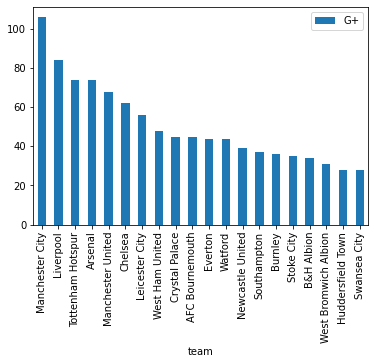

In [5]:
plotData = finalData.sort_values(by=['G+'], ascending = False)
plotData.plot(x = 'team', y = 'G+', kind = 'bar')

Manchester City zdecydowanie odbiega od reszty stawki i prowadzi w klasyfikacji zdobytych bramek.

<AxesSubplot:xlabel='team'>

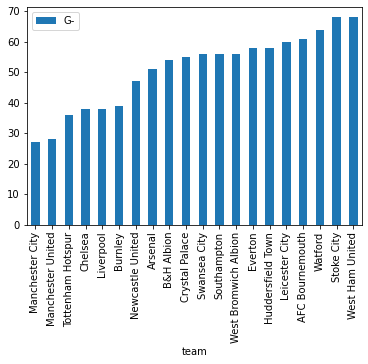

In [6]:
plotData = finalData.sort_values(by=['G-'], ascending = True)
plotData.plot(x = 'team', y = 'G-', kind = 'bar')

Obie drużyny z Manchesteru straciły zdecydowanie najmniej bramek a badanym sezonie. Za nimi w "grupie pościgowej" znajdują się kolejne cztery zespoły ze zbliżoną ilością goli.

<AxesSubplot:xlabel='team'>

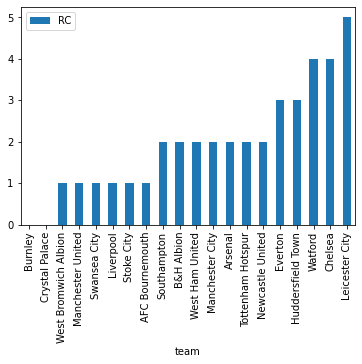

In [7]:
plotData = finalData.sort_values(by=['RC'], ascending = True)
plotData.plot(x = 'team', y = 'RC', kind = 'bar')

Kluby Burlney i Crystal Palace ani razu nie kończyły meczu w osłabieniu, za to Leicester zdarzyło się to najwięcej razy zapewne ze względu na swój agresywny i twardy styl gry.

<AxesSubplot:xlabel='team'>

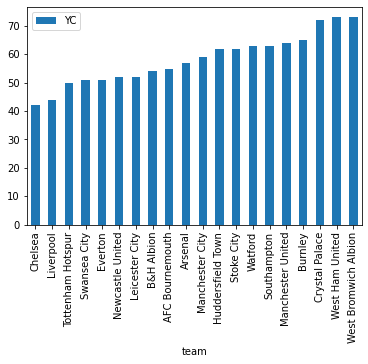

In [8]:
plotData = finalData.sort_values(by=['YC'], ascending = True)
plotData.plot(x = 'team', y = 'YC', kind = 'bar')

Klub Crystal Palace mimo braku czerwonej kartki jest w czołówce klasyfikacji zółtych kartoników.

<AxesSubplot:xlabel='team'>

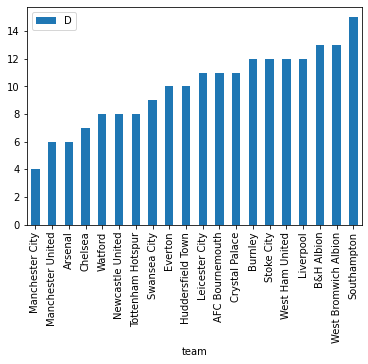

In [9]:
plotData = finalData.sort_values(by=['D'], ascending = True)
plotData.plot(x = 'team', y = 'D', kind = 'bar')

Manchester City jest wyraźnym liderem jeśli chodzi o ilość remisów. Zespół Southampton zdecydowanie przegrywa tą klasyfikacje. Oba zespoły wyróżniają się największymi względnymi różnicami ilości remisów w stosunku do sąsiadujących drużyn.

<AxesSubplot:xlabel='team'>

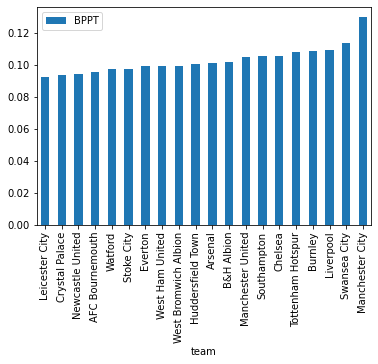

In [10]:
plotData = finalData.sort_values(by=['BPPT'], ascending = True)
plotData.plot(x = 'team', y = 'BPPT', kind = 'bar')

Manchester City zdecydowanie odstaje od reszty stawki pod względem wykonanych podań wstecznych. Może to być spowodowane sposobem gry tej drużyny, który charakteryzuje się dużym posiadaniem piłki. Pierwsza pozycja w tej klasyfikacji klubu Leicester City jest wynikiem gry polegającej na szybkich i zdecydowanych atakach.

#### Współczynniki zmienności

<AxesSubplot:>

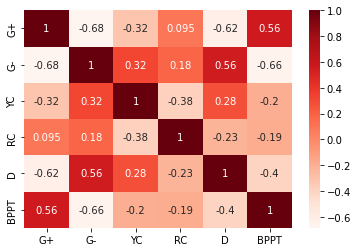

In [11]:
#corr = finalData.corr()
sb.heatmap(finalData.corr(), cmap="Reds", annot=True)

Za wyjątkiem jednej, wszystkie wartości współczynników mieszczą się w wymaganym przedziale [0,1:0,9]
Na tej podstawie czerwone kartki nie będą brane pod uwagę w dalszych badaniach.

In [12]:
finalData = finalData.drop(['RC'], axis=1)
finalData

,team,G+,G-,YC,D,BPPT
1,Manchester City,106.000,27.000,59.000,4.000,0.129
2,Manchester United,68.000,28.000,64.000,6.000,0.105
3,Tottenham Hotspur,74.000,36.000,50.000,8.000,0.108
4,Chelsea,62.000,38.000,42.000,7.000,0.105
5,Liverpool,84.000,38.000,44.000,12.000,0.109
6,Arsenal,74.000,51.000,57.000,6.000,0.101
7,Burnley,36.000,39.000,65.000,12.000,0.108
8,Everton,44.000,58.000,51.000,10.000,0.099
9,Leicester City,56.000,60.000,52.000,11.000,0.092
10,Newcastle United,39.000,47.000,52.000,8.000,0.094


## Porządkowanie liniowe

### Metoda Hellwiga

#### Hellwig stymulanty i destymulanty

Zamiana wszystkich zmiennych na stymulanty.

In [13]:
stymData = finalData.iloc[:, :3] 
destymData = -1*finalData.iloc[:, 3:7]
hellwigData = pd.concat([stymData, destymData], axis=1, join='inner')

hellwigData

,team,G+,G-,YC,D,BPPT
1,Manchester City,106.000,27.000,-59.000,-4.000,-0.129
2,Manchester United,68.000,28.000,-64.000,-6.000,-0.105
3,Tottenham Hotspur,74.000,36.000,-50.000,-8.000,-0.108
4,Chelsea,62.000,38.000,-42.000,-7.000,-0.105
5,Liverpool,84.000,38.000,-44.000,-12.000,-0.109
6,Arsenal,74.000,51.000,-57.000,-6.000,-0.101
7,Burnley,36.000,39.000,-65.000,-12.000,-0.108
8,Everton,44.000,58.000,-51.000,-10.000,-0.099
9,Leicester City,56.000,60.000,-52.000,-11.000,-0.092
10,Newcastle United,39.000,47.000,-52.000,-8.000,-0.094


#### Standaryzacja danych

In [14]:
normalizedData=round((hellwigData-hellwigData.mean())/hellwigData.std(),3)
normalizedData['team'] = hellwigData['team']
columnsTitles = ['team', 'G+', 'G-', "D", "YC", "BPPT"]
normalizedData = normalizedData.reindex(columns = columnsTitles)
normalizedData

,team,G+,G-,D,YC,BPPT
1,Manchester City,2.628,-1.917,2.087,-0.089,-3.133
2,Manchester United,0.816,-1.837,1.380,-0.647,-0.228
3,Tottenham Hotspur,1.102,-1.195,0.672,0.915,-0.628
4,Chelsea,0.529,-1.035,1.026,1.808,-0.290
5,Liverpool,1.579,-1.035,-0.743,1.585,-0.777
6,Arsenal,1.102,0.008,1.380,0.134,0.208
7,Burnley,-0.711,-0.954,-0.743,-0.759,-0.664
8,Everton,-0.329,0.569,-0.035,0.804,0.398
9,Leicester City,0.243,0.730,-0.389,0.692,1.245
10,Newcastle United,-0.568,-0.313,0.672,0.692,1.026


#### Wyznaczanie wzorca ("najlepszego" obiektu)



In [15]:
template = {
    "scored": normalizedData['G+'].max(),
    "conceded": normalizedData['G-'].max(),
    "draws": normalizedData['D'].max(),
    "yellowCards": normalizedData['YC'].max(),
    #"redCards": normalizedData['RC'].max(),
    "bppt": normalizedData['BPPT'].max()
}
template

{'scored': 2.628,
 'conceded': 1.371,
 'draws': 2.087,
 'yellowCards': 1.808,
 'bppt': 1.245}

#### Obliczenie odległości obiektów od wzorca

In [16]:
statsDistance = normalizedData.iloc[:,1:7]
statsDistance = (statsDistance - statsDistance.max())**2
statsDistance['distance'] = statsDistance.sum(axis=1)**(1/2)

dataToBeShown = round(statsDistance,2)
dataToBeShown['team'] = normalizedData['team']
dataToBeShown

,G+,G-,D,YC,BPPT,distance,team
1,0.000,10.810,0.000,3.600,19.170,5.790,Manchester City
2,3.280,10.290,0.500,6.030,2.170,4.720,Manchester United
3,2.330,6.580,2.000,0.800,3.510,3.900,Tottenham Hotspur
4,4.410,5.790,1.130,0.000,2.360,3.700,Chelsea
5,1.100,5.790,8.010,0.050,4.090,4.360,Liverpool
6,2.330,1.860,0.500,2.800,1.080,2.930,Arsenal
7,11.150,5.410,8.010,6.590,3.640,5.900,Burnley
8,8.740,0.640,4.500,1.010,0.720,3.950,Everton
9,5.690,0.410,6.130,1.250,0.000,3.670,Leicester City
10,10.210,2.840,2.000,1.250,0.050,4.040,Newcastle United


#### Stworzenie odległości "możliwie dalekiej".

In [17]:
d0 = statsDistance['distance'].mean() + 2 * statsDistance['distance'].std()
print(d0)
statsDistance

6.440838271352276


,G+,G-,D,YC,BPPT,distance
1,0.000,10.811,0.000,3.599,19.167,5.795
2,3.283,10.291,0.500,6.027,2.170,4.719
3,2.329,6.584,2.002,0.797,3.508,3.901
4,4.406,5.789,1.126,0.000,2.356,3.698
5,1.100,5.789,8.009,0.050,4.088,4.363
6,2.329,1.858,0.500,2.802,1.075,2.926
7,11.149,5.406,8.009,6.589,3.644,5.899
8,8.744,0.643,4.503,1.008,0.717,3.952
9,5.688,0.411,6.131,1.245,0.000,3.671
10,10.214,2.836,2.002,1.245,0.048,4.043


#### Wyznaczenie wartości miary dla każdego obiektu.

In [18]:
preSort = normalizedData.iloc[:,1:1]
preSort['hellwig'] = 1 - statsDistance['distance'] / d0
unorderedResult = pd.concat([preSort['hellwig'], normalizedData['team']], axis=1, join="inner")
unorderedResult

,hellwig,team
1,0.100,Manchester City
2,0.267,Manchester United
3,0.394,Tottenham Hotspur
4,0.426,Chelsea
5,0.323,Liverpool
6,0.546,Arsenal
7,0.084,Burnley
8,0.386,Everton
9,0.430,Leicester City
10,0.372,Newcastle United


#### Ostateczny ranking

In [19]:
result = unorderedResult.sort_values(by=['hellwig'], ascending = False)
result = result[['team', 'hellwig']]
result

,team,hellwig
6,Arsenal,0.546
9,Leicester City,0.430
4,Chelsea,0.426
3,Tottenham Hotspur,0.394
8,Everton,0.386
10,Newcastle United,0.372
13,Watford,0.366
11,AFC Bournemouth,0.356
5,Liverpool,0.323
2,Manchester United,0.267


Metoda Hellwiga wskazała  Arsenal jako najatrakcyjniejszą drużynę Premier League. Zwycięstwo może zawdzięczać wysokimi miejscami w każdej z badanych zmiennych. Tuż za nim plasuje się zespół Leicester. Na pewno pomogło mu w tym szybkość konstruowania akcji i stosunkowo mała ilość podań do tyłu. Najmniej warte oglądania okazały się  West Brom, Burnley oraz Southampton ze sporą stratą do reszty stawki. 

### Metoda standaryzowanych sum

#### Budowa syntetycznej miary
Na podstawie zestandaryzowanych danych oraz po zamianie zmiennych na stymulanty.

In [20]:
SynteticStats = normalizedData.iloc[:,1:7]
SynteticStats['team'] = normalizedData['team']
columnsTitles = ['team', 'G+', 'G-', "D", "YC", "BPPT","measure"]
SynteticStats = SynteticStats.reindex(columns = columnsTitles)
SynteticStats['measure'] = round((SynteticStats.iloc[:,1:7].sum(axis=1)/SynteticStats.iloc[:,1:7].count(axis=1)),10)

SynteticStats

,team,G+,G-,D,YC,BPPT,measure
1,Manchester City,2.628,-1.917,2.087,-0.089,-3.133,-0.085
2,Manchester United,0.816,-1.837,1.380,-0.647,-0.228,-0.103
3,Tottenham Hotspur,1.102,-1.195,0.672,0.915,-0.628,0.173
4,Chelsea,0.529,-1.035,1.026,1.808,-0.290,0.408
5,Liverpool,1.579,-1.035,-0.743,1.585,-0.777,0.122
6,Arsenal,1.102,0.008,1.380,0.134,0.208,0.566
7,Burnley,-0.711,-0.954,-0.743,-0.759,-0.664,-0.766
8,Everton,-0.329,0.569,-0.035,0.804,0.398,0.281
9,Leicester City,0.243,0.730,-0.389,0.692,1.245,0.504
10,Newcastle United,-0.568,-0.313,0.672,0.692,1.026,0.302


#### Standaryzacja uzyskanych wartości

In [21]:
SynteticStats2 = SynteticStats
columnsTitles = ['team', 'G+', 'G-', "D", "YC", "BPPT", "measure"]
SynteticStats2 = SynteticStats2.reindex(columns = columnsTitles)
SynteticStats2['sMeasure'] = (SynteticStats2['measure'] - SynteticStats2['measure'].min())/((SynteticStats2['measure'] - SynteticStats2['measure'].min()).max())

SynteticStats2

,team,G+,G-,D,YC,BPPT,measure,sMeasure
1,Manchester City,2.628,-1.917,2.087,-0.089,-3.133,-0.085,0.511
2,Manchester United,0.816,-1.837,1.380,-0.647,-0.228,-0.103,0.498
3,Tottenham Hotspur,1.102,-1.195,0.672,0.915,-0.628,0.173,0.705
4,Chelsea,0.529,-1.035,1.026,1.808,-0.290,0.408,0.881
5,Liverpool,1.579,-1.035,-0.743,1.585,-0.777,0.122,0.666
6,Arsenal,1.102,0.008,1.380,0.134,0.208,0.566,1.000
7,Burnley,-0.711,-0.954,-0.743,-0.759,-0.664,-0.766,0.000
8,Everton,-0.329,0.569,-0.035,0.804,0.398,0.281,0.786
9,Leicester City,0.243,0.730,-0.389,0.692,1.245,0.504,0.953
10,Newcastle United,-0.568,-0.313,0.672,0.692,1.026,0.302,0.801


#### Ostateczny ranking 2

In [22]:
result2 = SynteticStats2.sort_values(by=['sMeasure'], ascending = False)
result2 = result2[['team', 'sMeasure']]
result2

,team,sMeasure
6,Arsenal,1.000
9,Leicester City,0.953
4,Chelsea,0.881
13,Watford,0.804
10,Newcastle United,0.801
8,Everton,0.786
11,AFC Bournemouth,0.774
3,Tottenham Hotspur,0.705
5,Liverpool,0.666
19,Stoke City,0.587


Metoda standaryzowanych sum wskazała ponownie Arsenal jako najatrakcyjniejszy klub ligi angielskiej. Zwycięstwo może zawdzięczać wysokimi miejscami w każdej z badanych zmiennych. Tuż za nim plasuje się zespół Leicester. Na pewno pomogło mu w tym szybkość konstruowania akcji i stosunkowo mała ilość podań do tyłu. Najmniej warte oglądania również okazały się Burnley, West Brom oraz Southampton ze sporą stratą do reszty stawki. 

 Zestawiając ze sobą obie metody można zauważyć  spore podobieństwo i powtarzalność. Z większych różnic warto powiedzieć o spadku Tottenhamu z 4 na 8 lokatę oraz wejście Watfordu do czołowej czwórki. Ciekawe mogą się wydawać bardzo niskie miejsca(szczególnie w metodzie Hellwiga) Manchesteru City, czyli triumfatora tych rozgrywek. Być może ich gra nie przyciągnęła stosunkowo zbyt wielu kibiców ze względu na ich dominację, wysokie posiadanie piłki, duże rozmiary zwycięstwa, a co za tym idzie mało emocjonujące mecze wyparte z wyrównanej rywalizacji. Nie co wyżej, ale dalej niskie pozycje zajął Manchester United, o którym można powiedzieć właściwie to samo co o ich rywalu "zza miedzy". 

## Analiza skupień 

#### Wyznaczenie optymalnej ilości grup za pomocą metody łokciowej

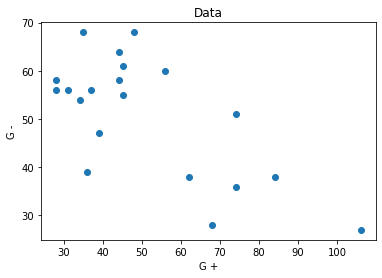

In [23]:
plt.plot()
plt.title('Data')
plt.scatter(finalData['G+'], finalData['G-'])
plt.xlabel('G +')
plt.ylabel('G -')
plt.show()

In [24]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(finalData.iloc[:,1:7])
    kmeanModel.fit(finalData.iloc[:,1:7])
  
    distortions.append(sum(np.min(cdist(finalData.iloc[:,1:7], kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / finalData.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(finalData.iloc[:,1:7], kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / finalData.shape[0]
    mapping2[k] = kmeanModel.inertia_

Metoda łokciowa z wykorzystaniem wartości zniekształceń.

Wartości odpowiadające ilościom potencjalnych grup.

In [25]:
# korzystanie z zniekształceń - distortions
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 23.08167509101984
2 : 13.965792763090267
3 : 12.123661855408942
4 : 10.622795024896194
5 : 9.332624227975789
6 : 8.434890216217585
7 : 7.732245148629724
8 : 6.664105303513898
9 : 5.850972442310568


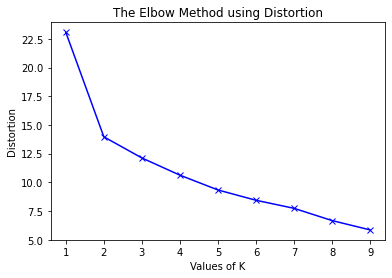

In [26]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Metoda łokciowa z wykorzystaniem wartości bezwładności.

Wartości odpowiadające ilościom potencjalnych grup.

In [27]:
# korzystaie z wartości bezwładności - inertias
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 12984.601389921398
2 : 4544.429551752006
3 : 3438.929077273497
4 : 2711.625403145268
5 : 2108.4670405018614
6 : 1756.250322647685
7 : 1584.3336257678625
8 : 1183.333646901217
9 : 934.0836141370971


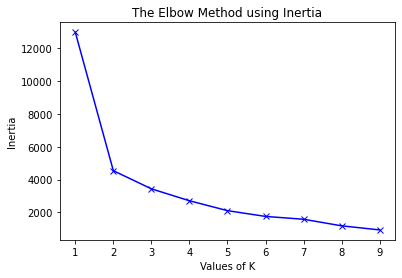

In [28]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Na obu wykresach widać, że po osiągnięciu wartości K=2 zaczynają one przypominać prostą. Zatem optymalna liczba grup to dwa.

### Grupowanie podziałowe

In [29]:
kmeans = KMeans(n_clusters=2).fit(finalData.iloc[:,1:7])
centroids = kmeans.cluster_centers_
print(centroids)

[[39.28571429 57.14285714 60.57142857 11.07142857  0.09964504]
 [78.         36.33333333 52.66666667  7.16666667  0.10952043]]


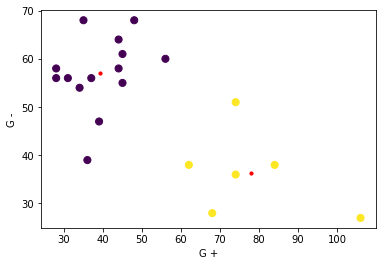

In [30]:
plt.scatter(finalData['G+'], finalData['G-'], c= kmeans.labels_.astype(float), s=50, alpha=1)
plt.xlabel('G +')
plt.ylabel('G -') 
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=10) #centroidy na czerwono
plt.show()

### Grupowanie hierarchiczne

In [31]:
groupingData = finalData.iloc[:,0:7]
groupingData

,team,G+,G-,YC,D,BPPT
1,Manchester City,106.000,27.000,59.000,4.000,0.129
2,Manchester United,68.000,28.000,64.000,6.000,0.105
3,Tottenham Hotspur,74.000,36.000,50.000,8.000,0.108
4,Chelsea,62.000,38.000,42.000,7.000,0.105
5,Liverpool,84.000,38.000,44.000,12.000,0.109
6,Arsenal,74.000,51.000,57.000,6.000,0.101
7,Burnley,36.000,39.000,65.000,12.000,0.108
8,Everton,44.000,58.000,51.000,10.000,0.099
9,Leicester City,56.000,60.000,52.000,11.000,0.092
10,Newcastle United,39.000,47.000,52.000,8.000,0.094


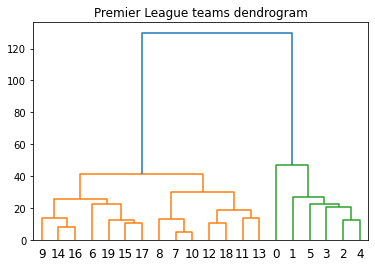

In [32]:
plt.figure()
plt.title("Premier League teams dendrogram")
selected_data = groupingData.iloc[:,1:]
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

Powyższy dendrogram pokazuje podział zespołów na dwie grupy, co ciekawe podział ten pokrywa się idealnie z utartym w Anglii podziałem na zespoły Big 6  (Man Utd, Man City, Arsenal, Chelsea, Liverpool, Tottenham) i resztę stawki. Kluby Big 6 charakteryzują znacznie większe budżety, oraz lepsze wyniki sportowe. Mają one rzesze kibiców na całym świecie, podczas gdy reszta stawki skupia raczej lokalnych fanów.

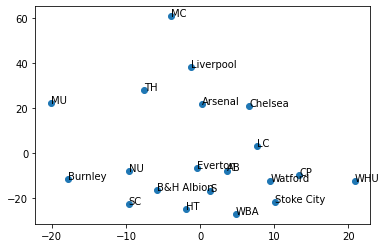

In [33]:
from sklearn.manifold import MDS
selected_data = groupingData.iloc[:,1:]
selected_data.shape

embedding = MDS(n_components=2)
selected_data = embedding.fit_transform(selected_data[:100])
X = []
Y = []
teams = []
for i in range(20):
    X.append(selected_data[i][0])
    Y.append(selected_data[i][1])
    teams.append(groupingData.iloc[i,0])

fig, ax = plt.subplots()
ax.scatter(X, Y)

def initials(fullname):
    if (len(fullname) > 10):
        return ''.join([x[0].upper() for x in fullname.split(' ')])
    else:
        return fullname

for i, txt in enumerate(teams):
    ax.annotate(initials(txt), (X[i], Y[i]))

Skalowanie wielowymiarowe pokazuje podobny podział na 2 grupy- Big 6 i resztę. Możnaby się zastanawiać, czy Manchester City, który absolutnie zdominował tamte rozgrywki zdobywając 100 punktów nie powinien być w całkowicie oddzielnej grupie.